In [70]:
# !pip install pandas matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.ticker as ticker

import os

In [2]:
log_file = "workload.log"
rq_stats_file = "range_queries.csv"

# CPU & IO Stats File
cpu_iostat_file = "cpu_iostat.txt"
cpu_top_file = "cpu_top.txt"
io_iostat_file = "io_iostat.txt"

CWD = os.getcwd()

In [3]:
def read_epochs_data(filename, time_stats=False):
    """Read `workload.log` file and return one epoch data"""
    
    with open(filename, 'r') as file:
        epoch_data = []
        grabbing_data = False
        for line in file:
            line = line.strip()
            if line.startswith("====================="):
                if grabbing_data:
                    yield epoch_data
                    epoch_data = []
                    grabbing_data = False
            elif grabbing_data:
                epoch_data.append(line)
            else:
                grabbing_data = True
                epoch_data.append(line)
        if time_stats:
            yield epoch_data

In [4]:
def extract_column_family(lines):
    """Extract Column Family information from one epoch data"""
    
    # Initialize variables to store column family data
    column_family_data = {"Levels": []}
    sst_files = {}
    i = 0

    # Process each line
    while i < len(lines):
        line = lines[i]
        # Check if the line contains column family data
        if line.startswith("Column Family Name"):
            key_val = line.split(',')
            column_family_data["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
            column_family_data["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            column_family_data["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
            column_family_data["Entries Count"] = int(key_val[3].split(':')[1].strip().strip(','))
            column_family_data["Invalid Entries Count"] = int(key_val[4].split(':')[1].strip().strip(','))
        if "Level:" in line:
            key_val = line.strip().split(',')
            level = int(key_val[0].split(":")[1].strip().strip(','))
            level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

            key_val_sst_files = lines[i+1].split('],')[:-1]
            sst_files = []
            
            for sst_file_string in key_val_sst_files:
                # Extract SST file details
                file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                file_details = sst_file_string.split(":")[1].strip().split()
                file_size = int(file_details[0].strip())
                smallest_key = int(file_details[1].strip(',').strip('('))
                largest_key = int(file_details[2].strip(')'))
                entries_count = int(file_details[3].strip(']'))

                sst_files.append({
                    "FNo": file_number,
                    "FileSize": file_size,
                    "SmallesKey": smallest_key,
                    "LargestKey": largest_key,
                    "EntriesCount": entries_count
                })
            
            if len(sst_files) > 0:
                column_family_data["Levels"].append({
                    "Level": level,
                    "LevelSize": level_size,
                    "LevelFilesCount": level_files_count,
                    "SSTFiles": sst_files
                })
            i += 1

        i += 1

    return column_family_data

In [5]:
def extract_total_write_bytes(one_epoch):
    """
    rocksdb.compact.read.bytes
    rocksdb.compact.write.bytes
    rocksdb.flush.write.bytes
    """
    read_bytes = 0
    write_bytes = 0

    for line in one_epoch:
        if line.startswith("rocksdb.compact.read.bytes"):
            read_bytes += int(line.split(':')[1])
        elif line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
            write_bytes += int(line.split(':')[1])
    
    return read_bytes, write_bytes

In [6]:
def get_execution_times(one_epoch):
    """
    Workload Execution Time: 
    Operations Execution Time: 
    All Inserts Time: 
    All Updates Time: 
    All Range Queries Time: 
    """
    workload_execution_time = 0
    operation_time = 0
    inserts_time = 0
    updates_time = 0
    range_queries_time = 0

    for line in one_epoch:
        if line.startswith("Workload Execution Time:"):
            workload_execution_time = int(line.split(':')[1].strip())
        if line.startswith("Operations Execution Time"):
            operation_time = int(line.split(':')[1].strip())
        if line.startswith("All Inserts Time"):
            inserts_time = int(line.split(':')[1].strip())
        if line.startswith("All Updates Time"):
            updates_time = int(line.split(':')[1].strip())
        if line.startswith("All Range Queries Time"):
            range_queries_time = int(line.split(':')[1].strip())

    return [workload_execution_time, operation_time, inserts_time, updates_time, range_queries_time]

In [7]:
# Find compaction debt, write amplification and entries per file

def compaction_debt(cfd_data):
    # Iterate through levels, summing up entries count for levels except the last one
    compaction_debt = 0

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    levels = list()
    flag = False

    for level in sorted_levels[::-1]:
        if flag:
            levels.append(level)
        elif not flag and level['SSTFiles'] != 0:
            flag = False
            levels.append(level)

    for level in levels[:-1]:
        for sst_file in level['SSTFiles']:
            compaction_debt += sst_file['EntriesCount']

    return compaction_debt

def write_amplification_debt(cfd_data):
    entries_per_level = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels:
        total_entries = 0
        for sst_file in level["SSTFiles"]:
            total_entries += sst_file['EntriesCount']
        entries_per_level.append(total_entries)

    lmax = len(entries_per_level)

    return sum([entries_per_level[index-1] * (lmax - index) for index in range(1, lmax)])

def write_amplification_debt_full(cfd_data):
    entries_per_level = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels:
        total_entries = 0
        for sst_file in level["SSTFiles"]:
            total_entries += sst_file['EntriesCount']
        entries_per_level.append(total_entries)

    lmax = len(entries_per_level)
    
    return entries_per_level[0] * (lmax - 1) + sum([entries_per_level[index-1] * (lmax - index + 1) for index in range(2, lmax+1)])

def write_amplification_debt_partial(cfd_data, size_ratio):
    entries_per_level = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels:
        total_entries = 0
        for sst_file in level["SSTFiles"]:
            total_entries += sst_file['EntriesCount']
        entries_per_level.append(total_entries)

    lmax = len(entries_per_level)

    return (entries_per_level[0] * (lmax - 1) + sum([entries_per_level[index-1] * (lmax - index + 1) for index in range(2, lmax+1)])) * (size_ratio / 2)


def avg_entries_per_SST_file(cfd_data):
    total_entries = 0
    total_sst_files = 0

    # Iterate through each level
    for level in cfd_data['Levels']:
        # Iterate through SST files in each level
        for sst_file in level['SSTFiles']:
            total_entries += sst_file['EntriesCount']
            # total_sst_files += 1
    
    return total_entries / cfd_data["Files Count"]
    # return total_entries / total_sst_files

In [8]:
# data = {
#     "Levels": [
#         {
#             "Level": 0,
#             "SSTFiles": [
#                 {
#                     "EntriesCount": 3
#                 }
#             ]
#         },
#         {
#             "Level": 1,
#             "SSTFiles": [
#                 {
#                     "EntriesCount": 5
#                 }
#             ]            
#         },
#         {
#             "Level": 2,
#             "SSTFiles": [
#                 {
#                     "EntriesCount": 8
#                 }
#             ]            
#         },
#         {
#             "Level": 3,
#             "SSTFiles": [
#                 {
#                     "EntriesCount": 12
#                 }
#             ]            
#         },
#         {
#             "Level": 4,
#             "SSTFiles": [
#                 {
#                     "EntriesCount": 50
#                 }
#             ]            
#         }
#     ]
# }

# print(write_amplification_debt(data))
# print(write_amplification_debt_full(data))
# print(write_amplification_debt_partial(data, 2))

In [9]:
def autolabel(rectangle_group):
    for rect in rectangle_group:
        height = rect.get_height()
        ax.annotate(f"{height}",
                xy = (rect.get_x() + rect.get_width() / 2, height),
                ha='center', color = 'grey', rotation=90, xytext=(0,5), textcoords="offset points")

def autolabel_percent(label_on_rect, compute_with_rect):
    for label_on, compute_from in zip(label_on_rect, compute_with_rect):
        label = (compute_from.get_height() - label_on.get_height()) / compute_from.get_height()
        height = label_on.get_height()
        ax.annotate(f"{label:.2f}",
                xy = (label_on.get_x() + label_on.get_width() / 2, height),
                ha='center', color = 'grey', rotation=90, xytext=(0,5), textcoords="offset points")

def convert_ns_to_sec(val):
    return val / (10**9)

In [10]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

# plot_for = [
#     # {
#     #     "inserts": 1000000,
#     #     "updates": 250000,
#     #     "range": 100,
#     #     "selectivity": 0.1,
#     #     "sizeRatio": 6,
#     #     "entrySize": 32,
#     #     "entriesPerPage": 128,
#     #     "lowerBound": 0.12,
#     #     "upperBound": 2,
#     # },
# ]
# lower_upper_bounds = list()

# for lb in lower_bounds:
#     for ub in upper_bounds:
#         if lb < ub:
#             lower_upper_bounds.append((lb, ub))
#             plot_for.append(
#                 {
#                     "inserts": 1000000,
#                     "updates": 250000,
#                     "range": 100,
#                     "selectivity": 0.1,
#                     "sizeRatio": 6,
#                     "entrySize": 128,
#                     "entriesPerPage": 32,
#                     "lowerBound": lb,
#                     "upperBound": ub,
#                 }
#             )


# FIG_SIZE = (10, 6)

# for exp in plot_for:
#     vanilla_dir_name = (
#         f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
#         f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
#     )
#     rqdc_dir_name = (
#         f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
#         f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
#         f"lb {exp['lowerBound']} ub {exp['upperBound']}"
#     )

#     if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
#         os.path.join(CWD, rqdc_dir_name)
#     ):
#         raise FileNotFoundError("Directory Not Found!!!")

#     first = True
#     vanilla_stats = list()
#     rqdc_stats = list()

#     vanilla_rq_stats = None
#     rqdc_rq_stats = None

#     for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
#         if first:
#             first = False
#         else:
#             cf_data = extract_column_family(one_epoch)
#             read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
#             one_epoch_cd = compaction_debt(cf_data)
#             one_epoch_wa = write_amplification_debt(cf_data)
#             one_epoch_epf = avg_entries_per_SST_file(cf_data)

#             vanilla_stats.append(
#                 {
#                     "CompactionDebtCount": one_epoch_cd,
#                     "WriteAmpDebtCount": one_epoch_wa,
#                     "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
#                     "AvgEntriesPerSST": one_epoch_epf,
#                     "FilesCount": cf_data["Files Count"],
#                     "DBSize": cf_data["Size"],
#                     "TotalEntries": cf_data["Entries Count"],
#                     "Invalid Entries": cf_data["Invalid Entries Count"],
#                     "TotalReadBytes": read_bytes,
#                     "TotalWriteBytes": write_bytes,
#                 }
#             )
#     vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
#     vanilla_rq_stats = vanilla_rq_stats.applymap(
#         lambda x: x.strip(" ") if isinstance(x, str) else x
#     )
#     vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

#     first = True

#     for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
#         if first:
#             first = False
#         else:
#             cf_data = extract_column_family(one_epoch)
#             read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
#             one_epoch_cd = compaction_debt(cf_data)
#             one_epoch_wa = write_amplification_debt(cf_data)
#             one_epoch_epf = avg_entries_per_SST_file(cf_data)

#             rqdc_stats.append(
#                 {
#                     "CompactionDebtCount": one_epoch_cd,
#                     "WriteAmpDebtCount": one_epoch_wa,
#                     "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
#                     "AvgEntriesPerSST": one_epoch_epf,
#                     "FilesCount": cf_data["Files Count"],
#                     "DBSize": cf_data["Size"],
#                     "TotalEntries": cf_data["Entries Count"],
#                     "Invalid Entries": cf_data["Invalid Entries Count"],
#                     "TotalReadBytes": read_bytes,
#                     "TotalWriteBytes": write_bytes,
#                 }
#             )
#     rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
#     rqdc_rq_stats = rqdc_rq_stats.applymap(
#         lambda x: x.strip(" ") if isinstance(x, str) else x
#     )
#     rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

#     x_tick_labels = [
#         "inserts",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "updates & RQ",
#         "inserts",
#     ]

#     # ============================================================================= #
#     #                    COMPACTION DEBT, WRITE AMP DEBT & DB SIZE                  #
#     # ============================================================================= #

#     width = 0.2
#     num_epochs = 12

#     x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
#     x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
#     x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
#     x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     ax2 = ax.twinx()

#     rect1 = ax.bar(
#         x_compaction_dbt_van,
#         [stat["CompactionDebtCount"] for stat in vanilla_stats],
#         width,
#         label="Compaction Debt (Vanilla)",
#         color="maroon",
#     )
#     rect2 = ax.bar(
#         x_compaction_dbt_rqdc,
#         [stat["CompactionDebtCount"] for stat in rqdc_stats],
#         width,
#         label="Compaction Debt (RQDC)",
#         color="olive",
#     )
#     rect3 = ax2.bar(
#         x_write_amp_dbt_van,
#         [stat["WriteAmpDebtCount"] for stat in vanilla_stats],
#         width,
#         label=("Write Amp Debt (Vanilla)"),
#         color="orange",
#     )
#     rect4 = ax2.bar(
#         x_write_amp_dbt_rqdc,
#         [stat["WriteAmpDebtCount"] for stat in rqdc_stats],
#         width,
#         label="Write Amp Debt (RQDC)",
#         color="cornflowerblue",
#     )
#     point1 = ax2.plot(
#         range(12),
#         [stat["DBSize"] for stat in vanilla_stats],
#         label="DB Size (Vanilla)",
#         color="red",
#         marker="o",
#     )
#     point2 = ax2.plot(
#         range(12),
#         [stat["DBSize"] for stat in rqdc_stats],
#         label="DB Size (RQDC)",
#         color="olivedrab",
#         marker="o",
#     )

#     ax.set_xticks(range(num_epochs))
#     ax.set_xticklabels(
#         x_tick_labels, rotation=60
#     )  # [f"{num}" for num in range(1, num_epochs + 1)])

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Compaction Debt (Count)")
#     ax.set_xlabel("Epoch")
#     ax.legend(loc="upper right")
#     ax.set_ylim(top=10**6.2)

#     ax2.set_ylabel("Write Amp Debt (Count) / Database Size (Bytes)")
#     ax2.legend(loc="upper left")

#     for recta, rectb in zip(rect1, rect2):
#         heighta = recta.get_height()
#         heightb = rectb.get_height()
#         ax.annotate(
#             f"{((heighta - heightb)/heighta):.2f}",
#             xy=(rectb.get_x() + rectb.get_width() / 2, heightb),
#             ha="center",
#             color="black",
#             rotation=90,
#             xytext=(0, 10),
#             textcoords="offset points",
#         )

#     for recta, rectb in zip(rect3, rect4):
#         heighta = recta.get_height()
#         heightb = rectb.get_height()
#         ax2.annotate(
#             f"{((heighta - heightb)/heighta):.2f}",
#             xy=(rectb.get_x() + rectb.get_width() / 2, heightb),
#             ha="center",
#             color="black",
#             rotation=90,
#             xytext=(0, 10),
#             textcoords="offset points",
#         )

#     i = 0
#     for p1, p2 in zip(
#         [stat["DBSize"] for stat in vanilla_stats],
#         [stat["DBSize"] for stat in rqdc_stats],
#     ):
#         ax2.annotate(
#             f"{((p1 - p2)/p2):.2f}",
#             xy=(i, p2),
#             ha="center",
#             color="black",
#             xytext=(0, -10),
#             textcoords="offset points",
#         )
#         i += 1

#     plt.show()

#     # ============================================================================= #
#     #                          VALID / INVALID ENTRIES COUNT                        #
#     # ============================================================================= #

#     width = 0.2
#     num_epochs = 12

#     x_total_entries_van = [x - 0.1 for x in range(num_epochs)]
#     x_total_entries_rqdc = [x + 0.1 for x in range(num_epochs)]
#     # x_total_invalid_entries_van = [x + 0.1 for x in range(num_epochs)]
#     # x_total_invalid_entries_rqdc = [x + 0.3 for x in range(num_epochs)]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     rect1 = ax.bar(
#         x_total_entries_van,
#         [stat["TotalEntries"] for stat in vanilla_stats],
#         width,
#         label="Total Entries (Vanilla)",
#         color="maroon",
#     )
#     rect2 = ax.bar(
#         x_total_entries_rqdc,
#         [stat["TotalEntries"] for stat in rqdc_stats],
#         width,
#         label="Total Entries (RQDC)",
#         color="olive",
#     )
#     # rect3 = ax.bar(
#     #     x_total_invalid_entries_van,
#     #     [stat["Invalid Entries"] for stat in vanilla_stats],
#     #     width,
#     #     label="Invalid Entries (Vanilla)",
#     #     color="red",
#     # )
#     # rect4 = ax.bar(
#     #     x_total_invalid_entries_rqdc,
#     #     [stat["Invalid Entries"] for stat in rqdc_stats],
#     #     width,
#     #     label="Invalid Entries (RQDC)",
#     #     color="orange",
#     # )

#     ax.axhline(y=exp["inserts"], linestyle="--", label="Total Unique Inserts")

#     ax.set_xticks(range(num_epochs))
#     ax.set_xticklabels(
#         x_tick_labels, rotation=60
#     )  # [f"{num}" for num in range(1, num_epochs + 1)])

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Total Valid / Invalid Entries (Count)")
#     ax.set_xlabel("Epoch")
#     ax.set_ylim(0, 15 * (10**5))
#     ax.legend()

#     autolabel(rect1)
#     autolabel(rect2)
#     # autolabel(rect3)
#     # autolabel(rect4)

#     plt.show()

#     # ============================================================================= #
#     #                  RANGE QUERIES Time + Entries Count                           #
#     # ============================================================================= #

#     width = 0.2
#     # x_useful_entries = [x-0.1 for x in range(exp['range'])]
#     # x_unuseful_entries = [x+0.1 for x in range(exp['range'])]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     ax2 = ax.twinx()

#     ax.plot(
#         range(exp["range"]),
#         vanilla_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
#         label="RQ's Time (Vanilla)",
#         color="maroon",
#     )
#     ax.plot(
#         range(exp["range"]),
#         rqdc_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
#         label="RQ's Time (RQDC)",
#         color="limegreen",
#     )

#     # ax2.bar(x_useful_entries, rqdc_rq_stats["uEntries Count Written Back"], width, label="Useful Entries")
#     # ax2.bar(x_unuseful_entries, rqdc_rq_stats["unEntries Count Written Back"], width, label="Unuseful Entries")

#     ax2.plot(
#         range(exp["range"]),
#         vanilla_rq_stats["Total Entries Read"],
#         label="Read Entries (Vanilla)",
#     )
#     ax2.plot(
#         range(exp["range"]),
#         rqdc_rq_stats["Total Entries Read"],
#         label="Read Entries (RQDC)",
#         color="orange",
#     )

#     # ax.set_xticks(range(exp['range']))
#     # ax.set_xticklabels(range(1, exp['range']+1), rotation=90)

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Range Queries Time (Seconds)")
#     ax.set_xlabel("Range Query Number")
#     ax.set_ylim(0, 0.5)

#     ax2.set_ylim(1, 150000)
#     ax2.set_ylabel("Total Entries Read for Range Query (Count)")
#     ax.legend()
#     ax2.legend(loc="upper left")

#     plt.show()

#     # ============================================================================= #
#     #                              RQ Useful + Unuseful entries                     #
#     # ============================================================================= #

#     # width = 0.2
#     # x_useful_entries = [x-0.1 for x in range(exp['range'])]
#     # x_unuseful_entries = [x+0.1 for x in range(exp['range'])]
#     bottom_unuseful = rqdc_rq_stats["uEntries Count Written Back"]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     # ax2 = ax.twinx()

#     # ax.plot(range(exp['range']), vanilla_rq_stats["RQ Total Time"].apply(convert_ns_to_sec), label="RQ's Time (Vanilla)", color="limegreen")
#     # ax.plot(range(exp['range']), rqdc_rq_stats["RQ Total Time"].apply(convert_ns_to_sec), label="RQ's Time (RQDC)", color="maroon")

#     ax.bar(
#         range(exp["range"]),
#         rqdc_rq_stats["uEntries Count Written Back"],
#         label="Useful Entries",
#     )
#     ax.plot(
#         range(exp["range"]),
#         vanilla_rq_stats["Total Entries Read"],
#         label="Read Entries (Vanilla)",
#     )
#     ax.bar(
#         range(exp["range"]),
#         rqdc_rq_stats["unEntries Count Written Back"],
#         bottom=bottom_unuseful,
#         label="Unuseful Entries",
#         color="indianred",
#     )
#     ax.plot(
#         range(exp["range"]),
#         rqdc_rq_stats["Total Entries Read"],
#         label="Read Entries (RQDC)",
#         color="maroon",
#     )

#     # ax2.plot(range(exp['range']), vanilla_rq_stats["Total Entries Read"], label="Read Entries (Vanilla)")
#     # ax2.plot(range(exp['range']), rqdc_rq_stats["Total Entries Read"], label="Read Entries (RQDC)", color="orange")

#     # ax.set_xticks(range(exp['range']))
#     # ax.set_xticklabels(range(1, exp['range']+1), rotation=90)

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Total Entries written back (Count)")
#     ax.set_xlabel("Range Query Number")

#     # ax2.set_ylim(1, 150000)
#     # ax2.set_ylabel("Total Entries Read for Range Query (Count)")
#     ax.legend()
#     # ax2.legend(loc="upper left")

#     plt.show()

#     # ============================================================================= #
#     #                           Number of SST File at diff epoch                    #
#     # ============================================================================= #

#     width = 0.2
#     num_epochs = 12

#     x_vanilla = [x - 0.1 for x in range(num_epochs)]
#     x_rqdc = [x + 0.1 for x in range(num_epochs)]

#     bottom_unuseful = rqdc_rq_stats["uEntries Count Written Back"]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     ax2 = ax.twinx()

#     ax.bar(
#         x_vanilla,
#         [stats["FilesCount"] for stats in vanilla_stats],
#         width,
#         label="Files Count (Vanilla)",
#     )
#     ax.bar(
#         x_rqdc,
#         [stats["FilesCount"] for stats in rqdc_stats],
#         width,
#         label="Files Count (RQDC)",
#     )

#     ax2.plot(
#         range(num_epochs),
#         [stats["AvgEntriesPerSST"] for stats in vanilla_stats],
#         marker="o",
#         color="maroon",
#         label="Avg Entries per SST (Vanilla)",
#     )
#     ax2.plot(
#         range(num_epochs),
#         [stats["AvgEntriesPerSST"] for stats in rqdc_stats],
#         marker="o",
#         color="limegreen",
#         label="Avg Entries per SST (RQDC)",
#     )

#     ax.set_xticks(range(num_epochs))
#     ax.set_xticklabels(
#         x_tick_labels, rotation=45
#     )  # [f"{num}" for num in range(1, num_epochs + 1)])

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Total Number of SST Files (Count)")
#     ax.set_xlabel("Epoch")

#     ax2.set_ylabel("Average Entries Per SST File")
#     ax2.set_ylim(0, max([stats["AvgEntriesPerSST"] for stats in rqdc_stats]) + 1000)

#     ax2.legend(loc="upper left")
#     ax.legend(loc="upper right")

#     plt.show()

#     # ============================================================================= #
#     #            Total Read Write Bytes over the Workload Execution                 #
#     # ============================================================================= #

#     width = 0.2
#     num_epochs = 12

#     x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
#     x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
#     x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
#     x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     # ax2 = ax.twinx()

#     rect1 = ax.bar(
#         x_compaction_dbt_van,
#         [stat["TotalReadBytes"] for stat in vanilla_stats],
#         width,
#         label="Vanilla Read",
#         color="maroon",
#     )
#     rect2 = ax.bar(
#         x_compaction_dbt_rqdc,
#         [stat["TotalReadBytes"] for stat in rqdc_stats],
#         width,
#         label="RQDC Read",
#         color="olive",
#     )
#     rect3 = ax.bar(
#         x_write_amp_dbt_van,
#         [stat["TotalWriteBytes"] for stat in vanilla_stats],
#         width,
#         label=("Vanilla Writes"),
#         color="orange",
#     )
#     rect4 = ax.bar(
#         x_write_amp_dbt_rqdc,
#         [stat["TotalWriteBytes"] for stat in rqdc_stats],
#         width,
#         label="RQDC Writes",
#         color="cornflowerblue",
#     )

#     ax.set_xticks(range(num_epochs))
#     ax.set_xticklabels(
#         x_tick_labels, rotation=45
#     )  # [f"{num}" for num in range(1, num_epochs + 1)])

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Read / Write Bytes")
#     ax.set_xlabel("Epoch")
#     ax.legend()

#     # autolabel(rect1)
#     # autolabel(rect2)
#     # autolabel(rect3)
#     # autolabel(rect4)

#     autolabel_percent(rect2, rect1)
#     autolabel_percent(rect4, rect3)

#     plt.show()


#     # ============================================================================= #
#     #   Stack the total bytes written and will be written to push everything down   #
#     # ============================================================================= #
    
#     fig, ax = plt.subplots(figsize=FIG_SIZE)

#     width = 0.2
#     num_epochs = 12

#     x_write_amp_dbt_van = [x - 0.1 for x in range(num_epochs)]
#     x_write_amp_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]

#     ax.bar(
#         x_write_amp_dbt_van,
#         [stat["TotalWriteBytes"] for stat in vanilla_stats],
#         width,
#         label=("Vanilla Writes"),
#         color="orange",
#     )
#     ax.bar(
#         x_write_amp_dbt_rqdc,
#         [stat["TotalWriteBytes"] for stat in rqdc_stats],
#         width,
#         label="RQDC Writes",
#         color="cornflowerblue",
#     )
#     ax.bar(
#         x_write_amp_dbt_van,
#         [stat["WriteAmpBytes"] for stat in vanilla_stats],
#         width,
#         label=("Write Amp Debt (Vanilla)"),
#         bottom=[stat["TotalWriteBytes"] for stat in vanilla_stats],
#         color="maroon",
#     )
#     ax.bar(
#         x_write_amp_dbt_rqdc,
#         [stat["WriteAmpBytes"] for stat in rqdc_stats],
#         width,
#         label="Write Amp Debt (RQDC)",
#         bottom=[stat["TotalWriteBytes"] for stat in rqdc_stats],
#         color="olive",
#     )

#     ax.set_xticks(range(num_epochs))
#     ax.set_xticklabels(
#         x_tick_labels, rotation=45
#     )  # [f"{num}" for num in range(1, num_epochs + 1)])

#     ax.set_title(
#         (
#             f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
#             f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
#         )
#     )
#     ax.set_ylabel("Total Writes + Write Amp Debt (Bytes)")
#     ax.set_xlabel("Epoch")
#     ax.legend()

#     plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


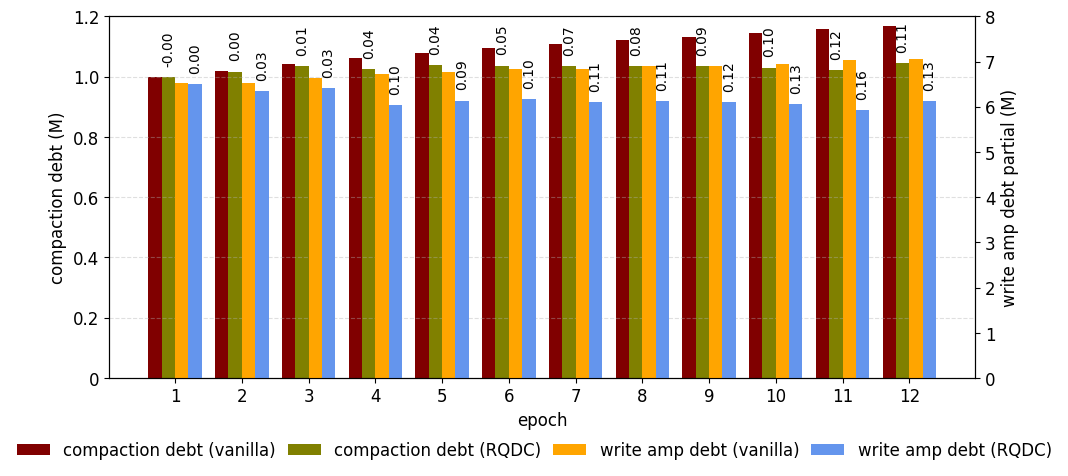

In [54]:
lower_bounds = [0.01] # [0.01, 0.1, 0.25]
upper_bounds = [0.25]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (10, 4.5)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt_partial(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt_partial(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]

    x_tick_labels = [f"{i}" for i in range(1, 13)]

    # ============================================================================= #
    #                    COMPACTION DEBT, WRITE AMP DEBT & DB SIZE                  #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax2 = ax.twinx()

    van_compaction_debt = ax.bar(
        x_compaction_dbt_van,
        [stat["CompactionDebtCount"] for stat in vanilla_stats],
        width,
        label="compaction debt (vanilla)",
        color="maroon",
    )
    rqdc_compaction_debt = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["CompactionDebtCount"] for stat in rqdc_stats],
        width,
        label="compaction debt (RQDC)",
        color="olive",
    )
    van_wa_dbt = ax2.bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpDebtCount"] for stat in vanilla_stats],
        width,
        label=("write amp debt (vanilla)"),
        color="orange",
    )
    rqdc_wa_debt = ax2.bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpDebtCount"] for stat in rqdc_stats],
        width,
        label="write amp debt (RQDC)",
        color="cornflowerblue",
    )
    # point1 = ax2.plot(
    #     range(12),
    #     [stat["DBSize"] for stat in vanilla_stats],
    #     label="db size (Vanilla)",
    #     color="red",
    #     marker="o",
    # )
    # point2 = ax2.plot(
    #     range(12),
    #     [stat["DBSize"] for stat in rqdc_stats],
    #     label="db size (RQDC)",
    #     color="olivedrab",
    #     marker="o",
    # )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12, # rotation=30
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12
    # )
    ax.set_ylabel("compaction debt (M)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)
    # ax.legend(loc="upper right")
    ax.set_ylim(bottom=0, top=1.2*(10**6))

    ax2.set_ylabel("write amp debt partial (M)", fontsize=12)
    ax2.set_ylim(bottom=0, top=8*(10**6))
    # ax2.legend(loc="upper left")

    for van_debt, rqdc_debt in zip(van_compaction_debt, rqdc_compaction_debt):
        heighta = van_debt.get_height()
        heightb = rqdc_debt.get_height()
        ax.annotate(
            f"{((heighta - heightb)/heighta):.2f}",
            xy=(rqdc_debt.get_x() + rqdc_debt.get_width() / 2, heightb),
            ha="center",
            color="black",
            rotation=90,
            xytext=(0, 10),
            textcoords="offset points",
            # fontsize=12,
        )

    for van_debt, rqdc_debt in zip(van_wa_dbt, rqdc_wa_debt):
        heighta = van_debt.get_height()
        heightb = rqdc_debt.get_height()
        ax2.annotate(
            f"{((heighta - heightb)/heighta):.2f}",
            xy=(rqdc_debt.get_x() + rqdc_debt.get_width() / 2, heightb),
            ha="center",
            color="black",
            rotation=90,
            xytext=(0, 10),
            textcoords="offset points",
            # fontsize=12,
        )

    # i = 0
    # for p1, p2 in zip(
    #     [stat["DBSize"] for stat in vanilla_stats],
    #     [stat["DBSize"] for stat in rqdc_stats],
    # ):
    #     ax2.annotate(
    #         f"{((p1 - p2)/p1):.2f}",
    #         xy=(i, p2),
    #         ha="center",
    #         color="black",
    #         xytext=(0, -10),
    #         textcoords="offset points",
    #         # fontsize=12,
    #     )
    #     i += 1

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax2.yaxis.set_major_locator(ticker.FixedLocator(ax2.get_yticks()))
    ax.set_yticklabels([f"{float(i/(1000*1000))}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    ax2.set_yticklabels([f"{int(i/(1000*1000))}" for i in ax2.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 0.04), frameon=False, columnspacing=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig("compaction-wa-debt.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


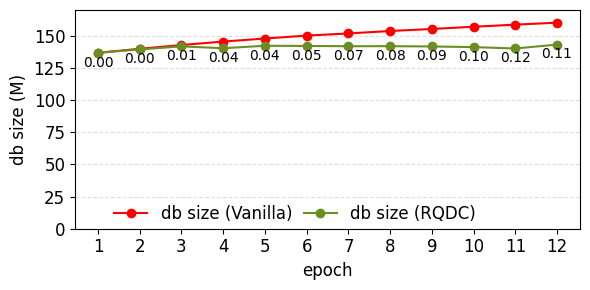

In [55]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [2]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (6, 3)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt_partial(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt_partial(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]

    x_tick_labels = [f"{i}" for i in range(1, 13)]

    # ============================================================================= #
    #                    COMPACTION DEBT, WRITE AMP DEBT & DB SIZE                  #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    point1 = ax.plot(
        range(12),
        [stat["DBSize"] for stat in vanilla_stats],
        label="db size (Vanilla)",
        color="red",
        marker="o",
    )
    point2 = ax.plot(
        range(12),
        [stat["DBSize"] for stat in rqdc_stats],
        label="db size (RQDC)",
        color="olivedrab",
        marker="o",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12, # rotation=30
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_ylabel("db size (M)", fontsize=12)
    ax.set_ylim(bottom=0, top=170*(10**6))
    # ax2.legend(loc="upper left")
    ax.set_xlabel("epoch", fontsize=12)
    i = 0
    for p1, p2 in zip(
        [stat["DBSize"] for stat in vanilla_stats],
        [stat["DBSize"] for stat in rqdc_stats],
    ):
        ax.annotate(
            f"{((p1 - p2)/p1):.2f}",
            xy=(i, p2),
            ha="center",
            color="black",
            xytext=(0, -10),
            textcoords="offset points",
            # fontsize=12,
        )
        i += 1

    # ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    # ax.set_yticklabels([f"{float(i/(1000*1000))}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    ax.set_yticklabels([f"{int(i/(1000*1000))}" for i in ax.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 0.35), frameon=False, columnspacing=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig("compaction-debt-dbsize.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


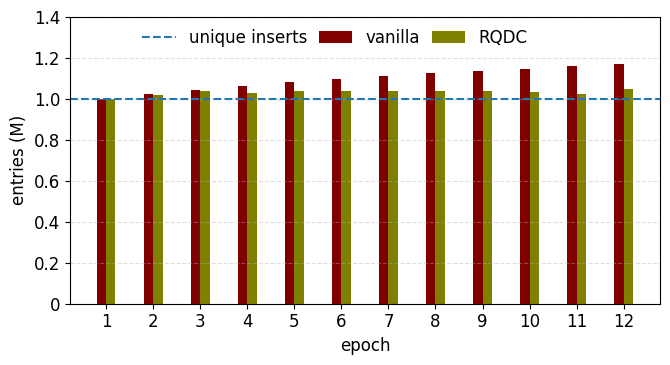

In [56]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (6.8, 3.75)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]
    x_tick_labels = [f"{i}" for i in range(1, 13)]

    # ============================================================================= #
    #                          VALID / INVALID ENTRIES COUNT                        #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_total_entries_van = [x - 0.1 for x in range(num_epochs)]
    x_total_entries_rqdc = [x + 0.1 for x in range(num_epochs)]
    # x_total_invalid_entries_van = [x + 0.1 for x in range(num_epochs)]
    # x_total_invalid_entries_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    van_entries = ax.bar(
        x_total_entries_van,
        [stat["TotalEntries"] for stat in vanilla_stats],
        width,
        label="vanilla",
        color="maroon",
    )
    rqdc_entries = ax.bar(
        x_total_entries_rqdc,
        [stat["TotalEntries"] for stat in rqdc_stats],
        width,
        label="RQDC",
        color="olive",
    )
    # rect3 = ax.bar(
    #     x_total_invalid_entries_van,
    #     [stat["Invalid Entries"] for stat in vanilla_stats],
    #     width,
    #     label="Invalid Entries (Vanilla)",
    #     color="red",
    # )
    # rect4 = ax.bar(
    #     x_total_invalid_entries_rqdc,
    #     [stat["Invalid Entries"] for stat in rqdc_stats],
    #     width,
    #     label="Invalid Entries (RQDC)",
    #     color="orange",
    # )

    ax.axhline(y=exp["inserts"], linestyle="--", label="unique inserts")

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12 #rotation=60
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )
    ax.set_ylabel("entries (M)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)
    ax.set_ylim(bottom=0, top=14*(10**5))
    # ax.legend()

    # autolabel(van_entries)
    # autolabel(rqdc_entries)
    # for rect in van_entries:
    #     height = rect.get_height()
    #     ax.annotate(f"{float(int(height)/(1000*1000)):.2f}",
    #             xy = (rect.get_x() + rect.get_width() / 2, height),
    #             ha='center', color = 'black', rotation=90, xytext=(0,5), textcoords="offset points")

    # for rect in rqdc_entries:
    #     height = rect.get_height()
    #     ax.annotate(f"{float(int(height)/(1000*1000)):.2f}",
    #             xy = (rect.get_x() + rect.get_width() / 2, height),
    #             ha='center', color = 'black', rotation=90, xytext=(0,5), textcoords="offset points")

    # autolabel(rect3)
    # autolabel(rect4)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels([f"{float(i/(1000*1000))}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.95), frameon=False, columnspacing=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig("valid-invalid-entries.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


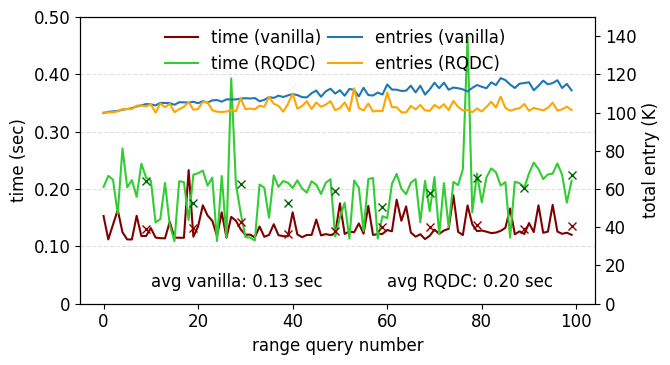

In [57]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

ROLLING_WINDOW = 10


def calculate_averages(dataframe, column_name):
    # Assuming the dataframe is sorted by range query number
    # Calculate the mean for every 10 entries
    averages = dataframe[column_name].rolling(window=ROLLING_WINDOW).mean().iloc[ROLLING_WINDOW-1::ROLLING_WINDOW].reset_index(drop=True)
    # Return the index where each group of 10 starts, and the corresponding average
    indices = np.arange(ROLLING_WINDOW-1, len(dataframe), ROLLING_WINDOW)
    return indices, averages

    

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (6.8, 3.75)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # ============================================================================= #
    #                  RANGE QUERIES Time + Entries Count                           #
    # ============================================================================= #

    # width = 0.2
    # x_useful_entries = [x-0.1 for x in range(exp['range'])]
    # x_unuseful_entries = [x+0.1 for x in range(exp['range'])]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax2 = ax.twinx()

    ax.plot(
        range(exp["range"]),
        vanilla_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
        label="time (vanilla)",
        color="maroon",
    )
    ax.plot(
        range(exp["range"]),
        rqdc_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
        label="time (RQDC)",
        color="limegreen",
    )

    # ax2.bar(x_useful_entries, rqdc_rq_stats["uEntries Count Written Back"], width, label="Useful Entries")
    # ax2.bar(x_unuseful_entries, rqdc_rq_stats["unEntries Count Written Back"], width, label="Unuseful Entries")

    # Use the function to calculate averages for vanilla and RQDC time data
    vanilla_indices, vanilla_time_averages = calculate_averages(vanilla_rq_stats, "RQ Total Time")
    rqdc_indices, rqdc_time_averages = calculate_averages(rqdc_rq_stats, "RQ Total Time")

    # Assuming `ax` is your time plot axis
    # Add averages to the plot, using a different linestyle or marker
    ax.plot(vanilla_indices, vanilla_time_averages.apply(convert_ns_to_sec), marker='x', linestyle='None', color='darkred')
    ax.plot(rqdc_indices, rqdc_time_averages.apply(convert_ns_to_sec), marker='x', linestyle='None', color='darkgreen')


    ax2.plot(
        range(exp["range"]),
        vanilla_rq_stats["Total Entries Read"],
        label="entries (vanilla)",
    )
    ax2.plot(
        range(exp["range"]),
        rqdc_rq_stats["Total Entries Read"],
        label="entries (RQDC)",
        color="orange",
    )

    # ax.set_xticks(range(exp['range']))
    # ax.set_xticklabels(range(1, exp['range']+1), rotation=90)

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )

    ax.set_ylabel("time (sec)", fontsize=12)
    ax.set_xlabel("range query number", fontsize=12)
    ax.set_ylim(bottom=0, top=0.5)

    ax2.set_ylim(bottom=0, top=150000)
    ax2.set_ylabel("total entry (K)", fontsize=12)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels([f"{i:.2f}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    
    ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    ax.set_xticklabels([f"{int(i)}" for i in ax.get_xticks()], fontsize=12)

    ax.annotate(f"avg vanilla: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)

    ax2.yaxis.set_major_locator(ticker.FixedLocator(ax2.get_yticks()))
    ax2.set_yticklabels([f"{int(i/(1000))}" if i != 0 else "0" for i in ax2.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.95), frameon=False, columnspacing=0.4)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig("range-query-time-entries.eps", format="eps", bbox_inches="tight", dpi=1200)
    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


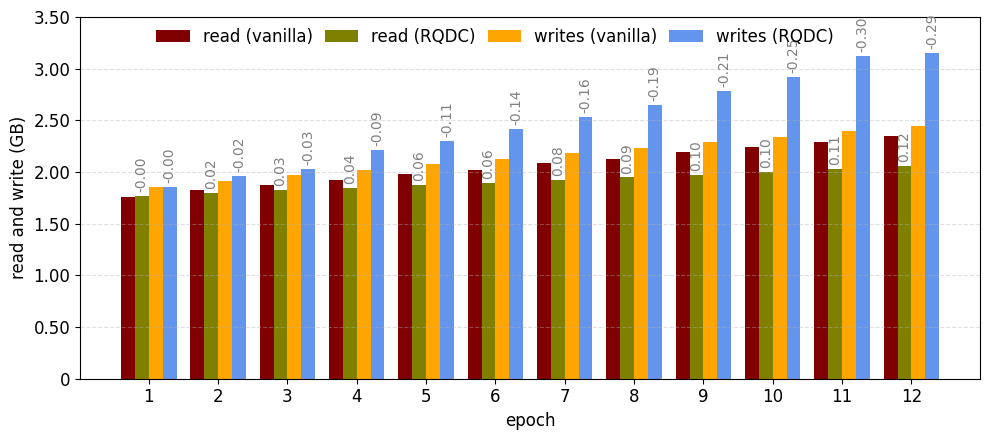

In [58]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (10, 4.5)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]
    x_tick_labels = [f"{i}" for i in range(1, 13)]


    # ============================================================================= #
    #            Total Read Write Bytes over the Workload Execution                 #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # ax2 = ax.twinx()

    rect1 = ax.bar(
        x_compaction_dbt_van,
        [stat["TotalReadBytes"] for stat in vanilla_stats],
        width,
        label="read (vanilla)",
        color="maroon",
    )
    rect2 = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["TotalReadBytes"] for stat in rqdc_stats],
        width,
        label="read (RQDC)",
        color="olive",
    )
    rect3 = ax.bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        label=("writes (vanilla)"),
        color="orange",
    )
    rect4 = ax.bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        label="writes (RQDC)",
        color="cornflowerblue",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12 # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )

    ax.set_ylabel("read and write (GB)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)
    ax.set_ylim(bottom=0, top=3.5*(1000**3))
    # ax.legend()

    # autolabel(rect1)
    # autolabel(rect2)
    # autolabel(rect3)
    # autolabel(rect4)

    autolabel_percent(rect2, rect1)
    autolabel_percent(rect4, rect3)

    # ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    # ax.set_xticklabels([f"{int(i)}" for i in ax.get_xticks()], fontsize=12)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 0.96), frameon=False, columnspacing=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # ax.annotate(f"avg vanilla read: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)
    # ax.annotate(f"avg vanilla: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)


    plt.tight_layout()


    plt.savefig("read-write-bytes.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


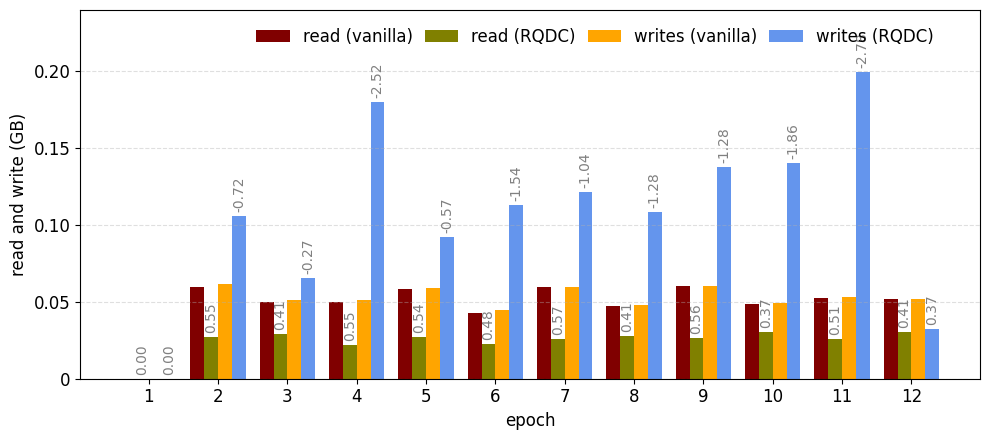

In [59]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (10, 4.5)

def get_for_each_epoch(stats, key):
    
    per_epoch = list()

    for index, write in enumerate(stats):
        if index == 0:
            per_epoch.append(1)
            # per_epoch.append(write[key])
        else:
            per_epoch.append(write[key] - stats[index-1][key])

    return per_epoch

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]
    x_tick_labels = [f"{i}" for i in range(1, 13)]


    # ============================================================================= #
    #            Total Read Write Bytes over the Workload Execution                 #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # ax2 = ax.twinx()

    rect1 = ax.bar(
        x_compaction_dbt_van,
        get_for_each_epoch(vanilla_stats, "TotalReadBytes"), # [stat["TotalReadBytes"] for stat in vanilla_stats],
        width,
        label="read (vanilla)",
        color="maroon",
    )
    rect2 = ax.bar(
        x_compaction_dbt_rqdc,
        get_for_each_epoch(rqdc_stats, "TotalReadBytes"), # [stat["TotalReadBytes"] for stat in rqdc_stats],
        width,
        label="read (RQDC)",
        color="olive",
    )
    rect3 = ax.bar(
        x_write_amp_dbt_van,
        get_for_each_epoch(vanilla_stats, "TotalWriteBytes"),  # [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        label=("writes (vanilla)"),
        color="orange",
    )
    rect4 = ax.bar(
        x_write_amp_dbt_rqdc,
        get_for_each_epoch(rqdc_stats, "TotalWriteBytes"), # [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        label="writes (RQDC)",
        color="cornflowerblue",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12 # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )

    ax.set_ylabel("read and write (GB)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)
    ax.set_ylim(bottom=0, top=max(get_for_each_epoch(rqdc_stats, "TotalWriteBytes"))+40000000)
    # ax.legend()

    # autolabel(rect1)
    # autolabel(rect2)
    # autolabel(rect3)
    # autolabel(rect4)

    autolabel_percent(rect2, rect1)
    autolabel_percent(rect4, rect3)

    # ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    # ax.set_xticklabels([f"{int(i)}" for i in ax.get_xticks()], fontsize=12)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.6, 0.96), frameon=False, columnspacing=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # ax.annotate(f"avg vanilla read: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)
    # ax.annotate(f"avg vanilla: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)


    plt.tight_layout()


    plt.savefig("read-write-every-epoch-non-cummulative.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


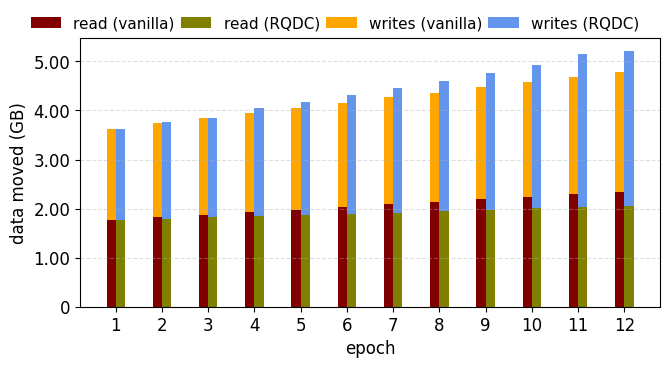

In [62]:
# lower_bounds = [0.01] # [0.01, 0.1, 0.25]
# upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (6.8, 3.5)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]
    x_tick_labels = [f"{i}" for i in range(1, 13)]


    # ============================================================================= #
    #            Total Read Write Bytes over the Workload Execution                 #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.1 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]
    # x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    # x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # ax2 = ax.twinx()

    rect1 = ax.bar(
        x_compaction_dbt_van,
        [stat["TotalReadBytes"] for stat in vanilla_stats],
        width,
        label="read (vanilla)",
        color="maroon",
    )
    rect2 = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["TotalReadBytes"] for stat in rqdc_stats],
        width,
        label="read (RQDC)",
        color="olive",
    )
    rect3 = ax.bar(
        x_compaction_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        bottom=[stat["TotalReadBytes"] for stat in vanilla_stats],
        label=("writes (vanilla)"),
        color="orange",
    )
    rect4 = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        bottom=[stat["TotalReadBytes"] for stat in rqdc_stats],
        label="writes (RQDC)",
        color="cornflowerblue",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, fontsize=12 # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax.set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )

    ax.set_ylabel("data moved (GB)", fontsize=12)
    ax.set_xlabel("epoch", fontsize=12)
    ax.set_ylim(bottom=0)
    # ax.legend()

    # autolabel(rect1)
    # autolabel(rect2)
    # autolabel(rect3)
    # autolabel(rect4)

    # autolabel_percent(rect2, rect1)
    # autolabel_percent(rect4, rect3)

    # ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
    # ax.set_xticklabels([f"{int(i)}" for i in ax.get_xticks()], fontsize=12)

    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax.get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, 1.06), frameon=False, columnspacing=0.4)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # ax.annotate(f"avg vanilla read: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)
    # ax.annotate(f"avg vanilla: {convert_ns_to_sec(vanilla_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(10,0.03), fontsize=12)
    # ax.annotate(f"avg RQDC: {convert_ns_to_sec(rqdc_rq_stats.mean()['RQ Total Time']):.2f} sec", xy=(60,0.03), fontsize=12)

    plt.tight_layout()

    plt.savefig("total-data-movement.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


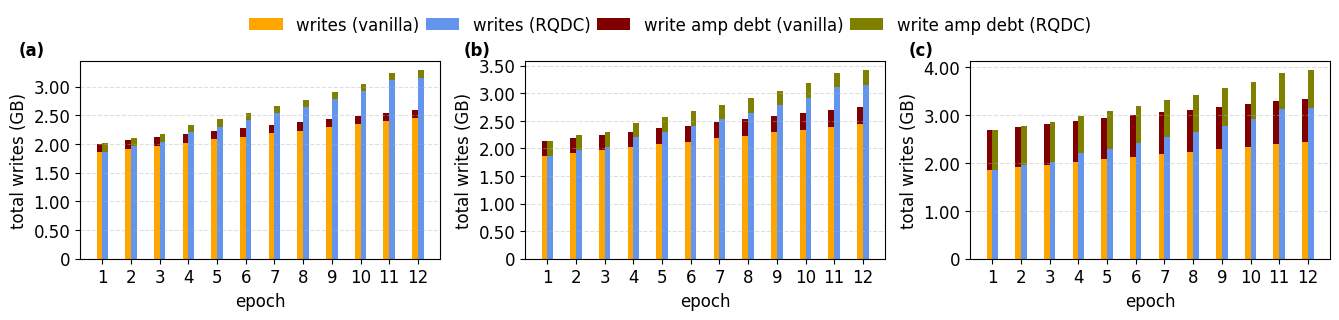

In [61]:

# lower_bounds = [0.25] # [0.01, 0.1, 0.25]
# upper_bounds = [2]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.1,
                    "sizeRatio": 6,
                    "entrySize": 128,
                    "entriesPerPage": 32,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (13.5, 3)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "WriteAmpBytesFull": write_amplification_debt_full(cf_data) * exp['entrySize'],
                    "WriteAmpBytesPartial": write_amplification_debt_partial(cf_data, exp['sizeRatio']) * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data)
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebtCount": one_epoch_cd,
                    "WriteAmpDebtCount": one_epoch_wa,
                    "WriteAmpBytes": one_epoch_wa * exp['entrySize'],
                    "WriteAmpBytesFull": write_amplification_debt_full(cf_data) * exp['entrySize'],
                    "WriteAmpBytesPartial": write_amplification_debt_partial(cf_data, exp['sizeRatio']) * exp['entrySize'],
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    # x_tick_labels = [
    #     "I",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "U & RQ",
    #     "I",
    # ]
    x_tick_labels = [f"{i}" for i in range(1, 13)]

    # ============================================================================= #
    #   Stack the total bytes written and will be written to push everything down   #
    # ============================================================================= #
    
    fig, ax = plt.subplots(1, 3, figsize=FIG_SIZE)

    width = 0.2
    num_epochs = 12

    x_write_amp_dbt_van = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]

    ax[0].bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        # label=("writes (vanilla)"),
        color="orange",
    )
    ax[0].bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        # label="writes (RQDC)",
        color="cornflowerblue",
    )
    ax[0].bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpBytes"] for stat in vanilla_stats],
        width,
        # label=("write amp debt (vanilla)"),
        bottom=[stat["TotalWriteBytes"] for stat in vanilla_stats],
        color="maroon",
    )
    ax[0].bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpBytes"] for stat in rqdc_stats],
        width,
        # label="write amp debt (RQDC)",
        bottom=[stat["TotalWriteBytes"] for stat in rqdc_stats],
        color="olive",
    )

    ax[0].set_xticks(range(num_epochs))
    ax[0].set_xticklabels(
        x_tick_labels, fontsize=12, # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax[0].set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )
    ax[0].set_ylabel("total writes (GB)", fontsize=12)
    ax[0].set_xlabel("epoch", fontsize=12)
    # ax[0].legend()

    ax[0].yaxis.set_major_locator(ticker.FixedLocator(ax[0].get_yticks()))
    ax[0].set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax[0].get_yticks()], fontsize=12)
    # fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 1.06), frameon=False, columnspacing=0.4)
    ax[0].grid(axis="y", linestyle="--", alpha=0.4)

    # plt.tight_layout()

    # plt.show()

    # ============================================================================= #
    #   Stack the total bytes written and will be written to push everything down   #
    # ============================================================================= #
    
    # fig, ax = plt.subplots(figsize=FIG_SIZE)

    width = 0.2
    num_epochs = 12

    x_write_amp_dbt_van = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]

    ax[1].bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        # label=("writes (vanilla)"),
        color="orange",
    )
    ax[1].bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        # label="writes (RQDC)",
        color="cornflowerblue",
    )
    ax[1].bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpBytesFull"] for stat in vanilla_stats],
        width,
        # label=("write amp debt (vanilla)"),
        bottom=[stat["TotalWriteBytes"] for stat in vanilla_stats],
        color="maroon",
    )
    ax[1].bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpBytesFull"] for stat in rqdc_stats],
        width,
        # label="write amp debt (RQDC)",
        bottom=[stat["TotalWriteBytes"] for stat in rqdc_stats],
        color="olive",
    )

    ax[1].set_xticks(range(num_epochs))
    ax[1].set_xticklabels(
        x_tick_labels, fontsize=12, # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax[1].set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )
    ax[1].set_ylabel("total writes (GB)", fontsize=12)
    ax[1].set_xlabel("epoch", fontsize=12)
    # ax[1].legend()

    ax[1].yaxis.set_major_locator(ticker.FixedLocator(ax[1].get_yticks()))
    ax[1].set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax[1].get_yticks()], fontsize=12)
    # fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 1.06), frameon=False, columnspacing=0.4)
    ax[1].grid(axis="y", linestyle="--", alpha=0.4)

    # plt.tight_layout()

    # plt.show()

    # ============================================================================= #
    #   Stack the total bytes written and will be written to push everything down   #
    # ============================================================================= #
    
    # fig, ax = plt.subplots(figsize=FIG_SIZE)

    width = 0.2
    num_epochs = 12

    x_write_amp_dbt_van = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]

    ax[2].bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        label=("writes (vanilla)"),
        color="orange",
    )
    ax[2].bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        label="writes (RQDC)",
        color="cornflowerblue",
    )
    ax[2].bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpBytesPartial"] for stat in vanilla_stats],
        width,
        label=("write amp debt (vanilla)"),
        bottom=[stat["TotalWriteBytes"] for stat in vanilla_stats],
        color="maroon",
    )
    ax[2].bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpBytesPartial"] for stat in rqdc_stats],
        width,
        label="write amp debt (RQDC)",
        bottom=[stat["TotalWriteBytes"] for stat in rqdc_stats],
        color="olive",
    )

    ax[2].set_xticks(range(num_epochs))
    ax[2].set_xticklabels(
        x_tick_labels, fontsize=12, # rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    # ax[2].set_title(
    #     (
    #         f'inserts {exp["inserts"]}, updates {exp["updates"]}, range queries {exp["range"]}, selectivity {exp["selectivity"]}'
    #         f'\nsize ratio {exp["sizeRatio"]}, entry size {exp["entrySize"]}, entries per page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
    #     ),
    #     fontsize=12,
    # )
    ax[2].set_ylabel("total writes (GB)", fontsize=12)
    ax[2].set_xlabel("epoch", fontsize=12)
    # ax[2].legend()

    ax[2].yaxis.set_major_locator(ticker.FixedLocator(ax[2].get_yticks()))
    ax[2].set_yticklabels([f"{float(i/(1000**3)):.2f}" if i != 0 else "0" for i in ax[2].get_yticks()], fontsize=12)
    fig.legend(loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 1.08), frameon=False, columnspacing=0.4)
    ax[2].grid(axis="y", linestyle="--", alpha=0.4)

    ax[0].text(x=-0.17, y=1.03, s='(a)', fontsize=12,
        horizontalalignment='left', 
        transform=ax[0].transAxes, fontweight='bold')
    ax[1].text(x=-0.17, y=1.03, s='(b)', fontsize=12,
        horizontalalignment='left', 
        transform=ax[1].transAxes, fontweight='bold')

    ax[2].text(x=-0.17, y=1.03, s='(c)', fontsize=12,
        horizontalalignment='left', 
        transform=ax[2].transAxes, fontweight='bold')


    plt.tight_layout()
    plt.savefig("total-writes.eps", format="eps", bbox_inches="tight", dpi=1200)

    plt.show()